In [1]:
import seastar as ss
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os
import xarray as xr
from scipy.ndimage import binary_dilation
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
#select files
date = '20220522'
track = '2'
gmf='mouche12'
L1c_folderpath = r'C:\Users\jwm1g23\OneDrive - University of Southampton\data\OSCAR\Iroise Sea 200x200m L1c'
lmout_folderpath = r'C:\Users\jwm1g23\OneDrive - University of Southampton\data\OSCAR\Iroise Sea 200x200m L2'
L1c = ss.utils.readers.readNetCDFFile(os.path.join(
    L1c_folderpath, f"{date}_Track_{track}_OSCAR_200x200m_L1c.nc"))
lmout = ss.utils.readers.readNetCDFFile(os.path.join(
    lmout_folderpath, f"{date}_Track_{track}_200x200m_{gmf}_lmout.nc"))

In [3]:
# input parameters
windspeed, winddirection = 5.466709137, 66.12411499 #for naive ambiguity removal
windcurrentratio = 2  # weight for the wind cost
iteration_number = 2  # number of iterations
#plotting
offset = -0.005  # adjust to change the offset of the extent
scale_cur = 40
scale_win = 175

In [4]:
def prepare_dataset(L2_sol):
    """
    Prepare the dataset for use in the OSCAR+ algorithm

    Returns a dataset without Antenna dimension and without x coordinate
    Uses sol2level2 function from seastar.retrieval.level2
    to compute the geophysical parameters

    Parameters
    ----------
    L2_sol : ``xarray.Dataset``
        L2 OSCAR data to prepare

    Returns
    -------
    L2 : ``xarray.Dataset``
        L2 OSCAR data without Antenna dimension, without x coordinate
        and with renamed data variables
    """
    L2 = xr.Dataset()
    # retrieve geophysical parameters
    L2 = ss.retrieval.level2.sol2level2(L2_sol)
    L2 = L2.mean(dim="Antenna")  # remove Antenna dimension
    L2 = L2.drop("x")  # remove x coordinate

    return L2

In [5]:
#compute land and beam mask
land_mask = ss.utils.tools.compute_land_mask_from_GSHHS(
    L1c.Sigma0.sel(Antenna="Mid"), quiet=True
)  # compute land masks
land_mask = xr.DataArray(
    binary_dilation(land_mask, iterations=2),
    coords=L1c.Sigma0.sel(Antenna="Mid").coords,
    dims=L1c.Sigma0.sel(Antenna="Mid").dims,
)
land_mask = xr.where(land_mask == 1, False, True)
# create a mask for each antenna with 1 where there is data and 0 where there is not
a = [xr.where(np.isnan(L1c.sel(Antenna=a).Sigma0), 0, 1) for a in L1c.Antenna.data]
# merge the antenna masks together
beam_mask = xr.where((a[0] + a[1] + a[2]) == 3, True, False)
# merge the land mask and the beam mask
mask = np.logical_and(beam_mask, land_mask)

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

In [6]:
# remove ambiguities for a start point
# Build geophysical dataset
geo = xr.Dataset()
geo["EarthRelativeWindSpeed"] = xr.DataArray(
    data=np.full(L1c.Sigma0.shape, windspeed),
    coords=L1c.Sigma0.coords,
    dims=L1c.Sigma0.dims,
)
geo["EarthRelativeWindDirection"] = xr.DataArray(
    data=np.full(L1c.Sigma0.shape, winddirection),
    coords=L1c.Sigma0.coords,
    dims=L1c.Sigma0.dims,
)
geo["CurrentVelocity"] = xr.DataArray(
    data=np.full(L1c.RSV.shape, 0), coords=L1c.RSV.coords, dims=L1c.RSV.dims
)
geo["CurrentDirection"] = xr.DataArray(
    data=np.full(L1c.RSV.shape, 0), coords=L1c.RSV.coords, dims=L1c.RSV.dims
)
# remove ambiguities
ambiguity = {'name':'closest_truth','method':'wind','truth':geo} #solve ambiguity by closest truth
L2_sol = ss.retrieval.ambiguity_removal.solve_ambiguity(
    lmout, ambiguity)  # solve ambiguity

lmout = xr.where(mask, lmout, np.nan) # apply the mask on L2_lmout

initial = prepare_dataset(L2_sol)  # create initial L2 dataset
lmout_prepped = prepare_dataset(
    lmout)  # create L2_lmout dataset
initial = xr.where(mask, initial, np.nan) # apply mask on L2

In [7]:
L2=ss.retrieval.spatial_ambiguity_selection.solve_ambiguity_spatial_selection(
    lmout_prepped,
    initial,
    iteration_number=iteration_number,
    inplace=False,
    method="windcurrent",
    windcurrentratio=windcurrentratio)

Pass 1
Pass 2


In [8]:
def plot_multiquiver(
    DS,
    u,
    v,
    extent,
    ax,
    title,
    color,
    legend_location="upper right",
    legend="none",
    scale=1,
    headwidth=3,
    headlength=5,
):
    """
    Plots multiple quiver plots on top of each other

    Parameters
    ----------
    DS : ``list`` of ``xarray.datasets``
        List of xarray datasets with longitude and latitude data coordinates
    u: ``string``
        name of the u component of the vector
    v: ``string``
        name of the v component of the vector
    extent: ``list``
        [eastmost longitude, westmost longitude, southmost latitude, northmost latitude]
        plot's extent
    ax : ``matplotlib.axes``
        axes to plot on
    title : ``string``
        title of the plot
    color : ``list`` of ``strings``
        list of colours for each quiver plot
    legend : ``list`` of ``strings``
        list of legends for each quiver plot
    scale : ``float``, optional
        scale for the quiver plots
        Default is 1
    headwidth : ``float``, optional
        width of the arrow head
        Default is 3
    headlength : ``float``, optional
        length of the arrow head
        Default is 5
    Returns
    -------
    None
    """
    # plot all quiver plots
    for i in range(0, len(DS)):
        DS[i].plot.quiver(
            x="longitude",
            y="latitude",
            u=u,
            v=v,
            pivot="tail",
            ax=ax,
            add_guide=False,
            color=color[i],
            scale=scale,
            headwidth=headwidth,
            headlength=headlength,
        )

    # add legend
    if legend is not None:
        legend_line = [0] * len(color)
        for i in range(0, len(color)):
            legend_line[i] = mlines.Line2D([], [], color=color[i], label=legend[i])
        ax.legend(handles=legend_line, fontsize=6, loc=legend_location)

    ax.set_title(title)  # adds subfigure title

    # add coastline and set extent
    ax.add_feature(
        cfeature.GSHHSFeature(scale="full", facecolor="beige", edgecolor="tan"),
        linewidth=2,
        zorder=3,
    )
    ax.set_extent(extent)

    # add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)  # adds gridlines
    gl.top_labels = False
    gl.right_labels = False

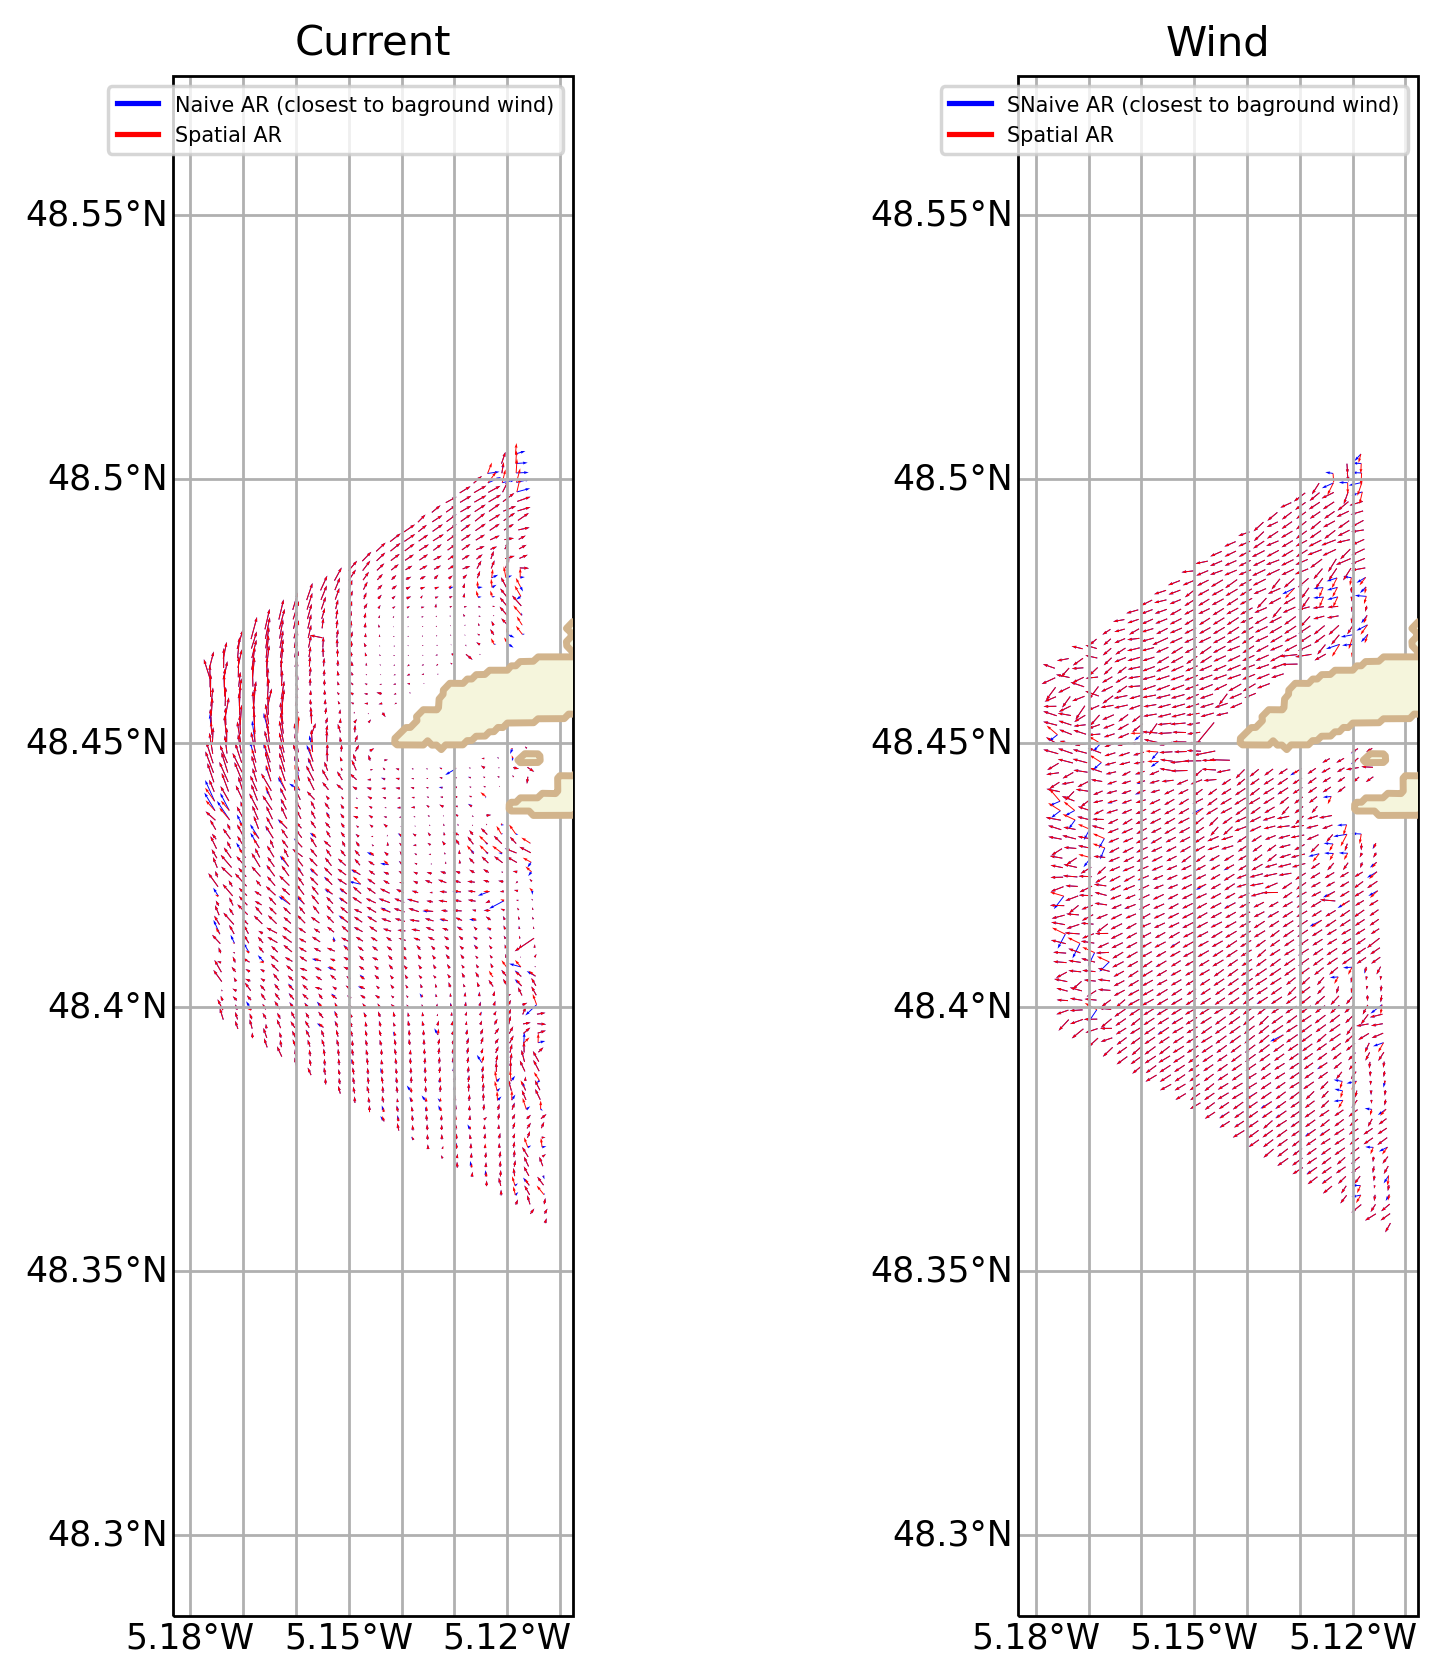

In [12]:
# plot currents on top of each other
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={
                         'wspace': 0.2, 'hspace': 0.007}, figsize=(8, 8), dpi=250)  # adjust to change figure size and resolution
# automatic extent, modified by offset due to the data being cut off when there's less than 3 looks
extent = [L2.longitude.min(), L2.longitude.max(
), L2.latitude.min()+offset, L2.latitude.max()-offset]

# left figure
plot_multiquiver([initial, L2], u='CurrentU', v='CurrentV', extent=extent, ax=axes[0], title='Current', color=[
                    'b', 'r'], legend=['Naive AR (closest to baground wind)', 'Spatial AR'], scale=scale_cur)
# right figure
plot_multiquiver([initial, L2], u='EarthRelativeWindU', v='EarthRelativeWindV', extent=extent, ax=axes[1],
                    title='Wind', color=['b', 'r'], legend=['SNaive AR (closest to baground wind)', 'Spatial AR'], scale=scale_win)